In [196]:
%run packages_imported.py
%run EDA.py

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
#df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_all_news_processed_post_dataset_distribution')

In [20]:
frame1 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'entertainment'][:1000]
frame2 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'financial'][:1000]
frame3 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'political'][:1000]
frame4 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'sport'][:1000]
frame5 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'technology'][:1000]
frame6 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'world'][:1000]
frame7 = df_all_news_processed.loc[df_all_news_processed['Category'] == 'travel'][:1000]

frames = [frame1, frame2, frame3, frame4, frame5, frame6, frame7]
df_processed_smaller = pd.concat(frames)
df_processed_smaller.reset_index()
df_processed_smaller.to_pickle('data/original_data/pickles/df_processed_smaller_before_tuning')

--------

In [2]:
df_all_news_processed = pd.read_pickle(r'data/original_data/pickles/df_processed_smaller_before_tuning')

In [4]:
t1 = time.time() 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7)
X = tfidfconverter.fit_transform(df_all_news_processed['Text']).toarray()

EDA.process_time(round(time.time()-t1))

Process completed.
Time taken: 2 seconds


In [113]:
from sklearn.model_selection import GridSearchCV

In [114]:
t1 = time.time() 

y = df_all_news_processed['Category']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

r_f_c = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, random_state=0)
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'log2']
}
CV_rfc = GridSearchCV(estimator=r_f_c, param_grid=param_grid, cv= 5)

CV_rfc.fit(X_train, y_train) 
print (CV_rfc.best_params_)
EDA.process_time(round(time.time()-t1))

{'max_features': 'log2', 'n_estimators': 700}
Process completed.
Time taken: 2mins 11secs


## Naive Bayes (Multinomial?)

In [7]:
from sklearn.naive_bayes import MultinomialNB

X = df_all_news_processed['Text']
Y = df_all_news_processed['Category']
distinct_categories = Y.drop_duplicates()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [4]:
algo_pipe = Pipeline([('Vect', CountVectorizer()),
               ('TFiDF-Tr', TfidfTransformer()),
               ('MNB', MultinomialNB())])

algo_pipe.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('Vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('TFiDF-tr',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('MNB',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
Y_pred = algo_pipe.predict(X_test)
######
print('Accuracy score: %s' % round(accuracy_score(Y_pred, Y_test), 5))
#algo_pipe.score(X_test, Y_test)
#####
print(classification_report(Y_test, Y_pred,target_names=distinct_categories))

Accuracy score: 0.66429
               precision    recall  f1-score   support

entertainment       0.69      0.81      0.74       203
    financial       0.64      0.78      0.70       224
    political       0.69      0.40      0.51       178
        sport       0.82      0.67      0.74       215
   technology       0.54      0.66      0.59       183
        world       0.69      0.72      0.70       186
       travel       0.63      0.58      0.60       211

     accuracy                           0.66      1400
    macro avg       0.67      0.66      0.66      1400
 weighted avg       0.67      0.66      0.66      1400



In [10]:
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__norm': ('l1', 'l2'),
    'clf__fit_prior': [True, False],
    'clf__alpha': [1, 0.6, 0.1, 1e-2, 1e-3, 1e-4]
}

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [11]:
t1 = time.time() 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import TfidfTransformer

clf = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring='accuracy')
clf.fit(X_train, Y_train)

print(classification_report(Y_test, clf.predict(X_test), digits=4))

print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7419    0.7931    0.7667       203
    financial     0.7034    0.7411    0.7217       224
    political     0.6125    0.5506    0.5799       178
        sport     0.8242    0.6977    0.7557       215
   technology     0.5614    0.6995    0.6229       183
       travel     0.7500    0.7258    0.7377       186
        world     0.6345    0.5924    0.6127       211

     accuracy                         0.6879      1400
    macro avg     0.6897    0.6857    0.6853      1400
 weighted avg     0.6932    0.6879    0.6882      1400

Best Score:  0.7008928571428571
Best Params:  {'clf__alpha': 0.01, 'clf__fit_prior': False, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2), 'tfidf__norm': 'l1', 'tfidf__use_idf': True}
Process completed.
Time taken: 4h 48mins 22secs


In [68]:
clf.best_params_

{'clf__alpha': 0.6, 'clf__fit_prior': False, 'tfidf__norm': 'l1'}

In [55]:
clf.best_score_

0.6883928571428571

## Support Vector Machine (SVM)

In [98]:
from sklearn.linear_model import SGDClassifier
t1 = time.time() 

algo_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('sgd', SGDClassifier())])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

'''

('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None))]
sdg.fit(X_train, Y_train)
y_pred = sdg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=distinct_categories))
EDA.process_time(round(time.time()-t1))'''

tuned_parameters = {
    'sgd__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'sgd__loss': ['hinge', "log", "modified_huber", "perceptron", "squared_hinge"],
    'sgd__penalty': ['l1', 'l2'],
    'sgd__random_state': [42],
    'sgd__n_iter_no_change': [30],
    'sgd__tol': [None],
    'sgd__n_jobs': [-1]
}


sgd = GridSearchCV(algo_pipe, tuned_parameters, cv=10, scoring='accuracy')
sgd.fit(x_train, y_train)

y_pred = sgd.predict(x_test)

print(classification_report(y_test, y_pred, digits=4))

print("Best Score: ", sgd.best_score_)
print("Best Params: ", sgd.best_params_)
EDA.process_time(round(time.time()-t1))

               precision    recall  f1-score   support

entertainment     0.7364    0.7980    0.7660       203
    financial     0.7535    0.7232    0.7380       224
    political     0.5829    0.6124    0.5973       178
        sport     0.7682    0.7860    0.7770       215
   technology     0.5991    0.6940    0.6430       183
       travel     0.7798    0.7043    0.7401       186
        world     0.6798    0.5735    0.6221       211

     accuracy                         0.7007      1400
    macro avg     0.6999    0.6988    0.6976      1400
 weighted avg     0.7038    0.7007    0.7006      1400

Best Score:  0.7160714285714286
Best Params:  {'sgd__alpha': 0.001, 'sgd__loss': 'modified_huber', 'sgd__n_iter_no_change': 30, 'sgd__n_jobs': -1, 'sgd__penalty': 'l2', 'sgd__random_state': 42, 'sgd__tol': None}
Process completed.
Time taken: 1h 53mins 53secs


In [ ]:
'''
Best Score:  0.7039285714285715
Best Params:  {'sgd__alpha': 0.0001, 'sgd__loss': 'hinge', 'sgd__n_iter_no_change': 30, 'sgd__n_jobs': -1, 'sgd__penalty': 'l2', 'sgd__random_state': 42, 'sgd__tol': None}
Process completed.
Time taken: 1h 50mins 12secs

for x, y in sgd.cv_results_.items():
    print(x)
    print(y)
    print("---")

''

In [124]:
#save the gridSearchResults as pickle file
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'wb') as handle:
    pickle.dump(sgd, handle, protocol=pickle.HIGHEST_PROTOCOL)
'''# reload the object
with open('data/GridSearch_results/sgd_GridSearchCV.pkl', 'rb') as handle:
    grid_reloaded = pickle.load(handle)'''

In [99]:
#import plotly.express as px
fig = px.scatter(x=list(sgd.cv_results_['param_sgd__alpha']), 
                y=list(sgd.cv_results_['mean_test_score']), 
                labels={
                    "x": "Alpha Values",
                    "y": "Scores"
                },
                    title="SDG Alpha Best Scores based on their Accuracy")
fig.show()

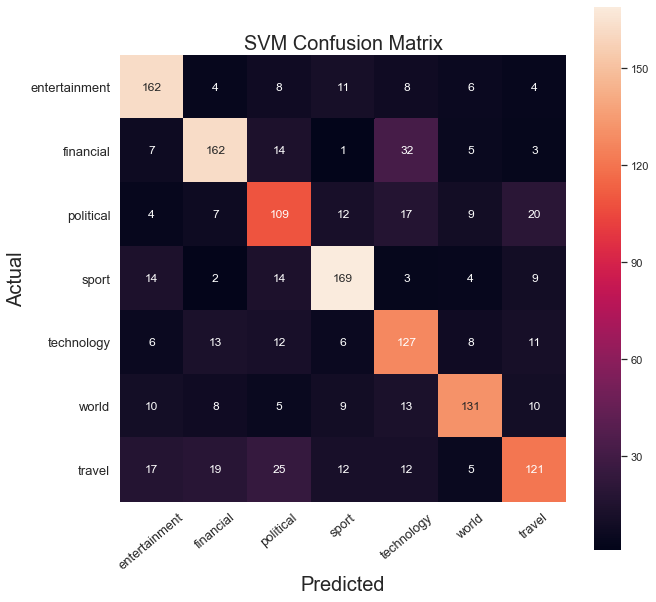

In [197]:
#plot_title = "SVM Confusion Matrix"
display_confusion_matrix(y_test, y_pred, distinct_categories, plot_title="SVM Confusion Matrix")

## Random Forest

In [ ]:
#https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn
#https://stackoverflow.com/questions/48554577/hyperparameter-tuning-random-forest-classifier-with-gridsearchcv-based-on-probab
#https://stackoverflow.com/questions/23045318/scikit-grid-search-over-multiple-classifiers

## XGBoost

## Logistic Regression

## K Nearest Neighbour (?)